## **Establish connection with github using SSH protocol.**

In [1]:
# Mount the google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# ssh keys were generated earlier. Private and Public keys are stored in 
# 'colabkey' and 'colabkey.pub' files. Additionally a config file is also 
# stored in /content/drive/MyDrive/ssh_keys/ on google drive.

# Remove ssh folder and its contents if already present
!rm -rf /root/.ssh

# Create a directory
!mkdir /root/.ssh

# Copy everything (ssh_key files & config file) from google drive to Virtual Machine.  
!cp /content/drive/MyDrive/ssh_keys/* /root/.ssh

# Set permission
!chmod 700 /root/.ssh  

In [3]:
# Add the git server as an ssh known host
!touch /root/.ssh/known_hosts

# Trust github  
!ssh-keyscan github.com >> /root/.ssh/known_hosts

# Set permission  
!chmod 644 /root/.ssh/known_hosts  

# github.com:22 SSH-2.0-babeld-c7c9be80
# github.com:22 SSH-2.0-babeld-c7c9be80
# github.com:22 SSH-2.0-babeld-c7c9be80
# github.com:22 SSH-2.0-babeld-c7c9be80
# github.com:22 SSH-2.0-babeld-c7c9be80


In [4]:
# Run ssh-agent and add `ssh-add /root/.ssh/colabkey` in the prompt. 
# After this command, optinally check if the key is saved using `ssh-add -l`, 
# then exit the prompt.
!ssh-agent /bin/bash

bash: cannot set terminal process group (290): Inappropriate ioctl for device
bash: no job control in this shell
/content# ssh-add /root/.ssh/colabkey
Identity added: /root/.ssh/colabkey (shreyasdb99@gmail.com)
/content# exit
exit


In [5]:
# Check connection with github
!ssh -T git@github.com

Hi shre-db! You've successfully authenticated, but GitHub does not provide shell access.


In [6]:
# Navigate to the project folder
cd drive/MyDrive/ColabProjects/A-Curious-FFN

/content/drive/MyDrive/ColabProjects/A-Curious-FFN


In [7]:
!ls

A_Curious_FFN.ipynb  README.md


## **Initialize git repository if not already**

In [8]:
# Initialize the directory as a git repository (if not already)
# !git init

Initialized empty Git repository in /content/drive/MyDrive/ColabProjects/A-Curious-FFN/.git/


In [9]:
# Configure user name and email (if not already)
# !git config user.name "shre-db"
# !git config user.email "shreyasdb99@gmail.com"

In [28]:
# Check Staging Area
!git status

On branch master

No commits yet

Untracked files:
  (use "git add <file>..." to include in what will be committed)
	A_Curious_FFN.ipynb
	README.md

nothing added to commit but untracked files present (use "git add" to track)


In [ ]:
# Add Commit and Push
!git add README.md 
!git add A_Curious_FFN.ipynb
!git commit -m "Add README and Notebook" -m "This commit includes a basic FFN model."
!git branch -M main
!git remote add origin git@github.com:shre-db/A-Curious-FFN.git
!git push -u origin main

[master (root-commit) 6e2925c] Add README and Notebook
 2 files changed, 1 insertion(+)
 create mode 100644 A_Curious_FFN.ipynb
 create mode 100644 README.md
Enumerating objects: 4, done.
Counting objects: 100% (4/4), done.
Delta compression using up to 2 threads
Compressing objects: 100% (3/3), done.
Writing objects: 100% (4/4), 26.24 KiB | 3.28 MiB/s, done.
Total 4 (delta 0), reused 0 (delta 0)
To github.com:shre-db/A-Curious-FFN.git
 * [new branch]      main -> main
Branch 'main' set up to track remote branch 'main' from 'origin'.


## **Use cells in this section to execute commands**

In [ ]:
!git status

In [ ]:
!git add A_Curious_FFN.ipynb
!git commit -m " " -m " "
!git push

In [ ]:
!ls

## **Working with data**

In [8]:
# Import Libraries
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

In [9]:
# Gather original MNIST data.
from sklearn.datasets import fetch_openml
mnist_org = fetch_openml('mnist_784', version=1, as_frame=False)

In [10]:
mnist_org.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [11]:
data = mnist_org.data
data

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [12]:
targets = mnist_org.target
targets

array(['5', '0', '4', ..., '4', '5', '6'], dtype=object)

In [13]:
print(data.min())
print(data.max())

0.0
255.0


In [14]:
# Scale the data using minmax scaler to a range of 0 - 1.
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
data = scaler.fit_transform(data)
data

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [16]:
data.dtype

dtype('float64')

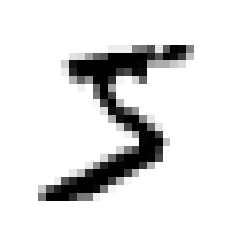

In [17]:
# Plot an image

number = data[0,:].reshape(28, 28)

plt.imshow(number, mpl.cm.binary)
plt.axis("off")
plt.show()

## **Create Train and Test groups using DataLoader**

In [18]:
 # Convert data and labels to pytorch tensors
dataT = torch.tensor(data).float()
targT = torch.tensor(targets.astype(int)).long()

In [19]:
# Split the data into train and test sets
from sklearn.model_selection import StratifiedShuffleSplit
ss_split = StratifiedShuffleSplit(n_splits=1, test_size=0.10, random_state=42)
for train_index, test_index in ss_split.split(dataT, targT):
  X_train, X_test, y_train, y_test = dataT[train_index, :], dataT[test_index, :], targT[train_index], targT[test_index] 

In [20]:
# Convert to Pytorch Datasets
train_data = TensorDataset(X_train, y_train)
test_data = TensorDataset(X_test, y_test)

In [21]:
# Translate into dataloader objects
batchsize = 128
train_loader = DataLoader(train_data, batch_size=batchsize, shuffle=True, drop_last=True)
test_loader = DataLoader(test_data, batch_size=test_data.tensors[0].shape[0])

## **Create a Feed Forward Network**

In [22]:
def createCuriousFFN():
    """
    A function to create a FFN Model.
    """
    # Architecture
    class CuriousFFN(nn.Module):
        
        # initialize input layer, hidden layers, output layer and their number of units respectively.
        def __init__(self) -> None:
            super().__init__()

            # input layer
            self.input = nn.Linear(784, 64)

            # hidden layers
            self.hidden1 = nn.Linear(64, 64)
            self.hidden2 = nn.Linear(64, 64)

            # output layer
            self.output = nn.Linear(64, 10)
    
        # forward pass
        def forward(self, X):
            X = F.relu(self.input(X))
            X = F.relu(self.hidden1(X))
            X = F.relu(self.hidden2(X))
            # return raw output
            return torch.log_softmax(self.output(X), axis=1)

    # Model instance
    net = CuriousFFN()
    
    # Loss funtion
    lossfun = nn.NLLLoss()

    # Optimizer
    optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

    return net, lossfun, optimizer

In [25]:
def trainCuriousFFN(net, lossfun, optimizer):
    """
    A function to train a FFN model.
    """
    # Set number of iterations for training
    numepochs = 20

    # Initialize losses and accuracies
    losses = torch.zeros(numepochs)
    train_acc = []
    test_acc = []

    # Loop over numepochs
    for epoch in range(numepochs):

        # Initialize batch losses and accuracies
        batch_loss = []
        batch_acc = []

        # Loop over minibatches from train_loader
        for X, y in train_loader:

            # Forward prop
            yHat = net(X)

            # Loss function
            loss = lossfun(yHat, y)

            # Back prop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Compute and store losses from this batch
            batch_loss.append(loss.item())

            # Compute and store accuracies
            batch_acc.append(torch.mean((torch.argmax(yHat,axis=1) == y).float())*100)
            
        # Compute and store average loss across batches
        losses[epoch] = np.mean(batch_loss)

        # Compute and store average training acuracy
        train_acc.append(np.mean(batch_acc))

        # --------- Test Accuracy computation is disabled --------- #

        # Test accuracy
        X, y = next(iter(test_loader))
        with torch.no_grad():
            yHat = net(X)

        # Compute and store test accuracy
        test_acc.append(torch.mean((torch.argmax(yHat, axis=1) == y).float())*100)

    return net, losses, train_acc, test_acc

In [26]:
# Create a model
ffn, lossf, optim = createCuriousFFN()

# Train the model
ffn, losses, train_acc, test_acc = trainCuriousFFN(net=ffn, lossfun=lossf, optimizer=optim)

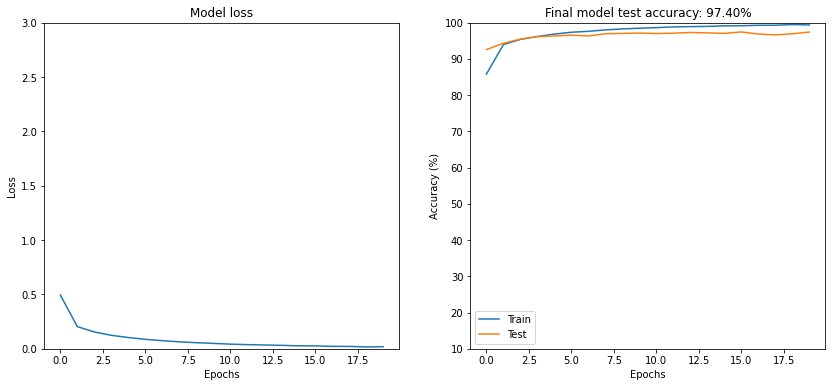

In [27]:
# Visualize the performance
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

ax[0].plot(losses)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_ylim([0,3])
ax[0].set_title('Model loss')

ax[1].plot(train_acc,label='Train')
ax[1].plot(test_acc,label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_ylim([10,100])
ax[1].set_title(f'Final model test accuracy: {test_acc[-1]:.2f}%')
ax[1].legend()

plt.show()